# Introduction 

This notebook will produce exploratory data analysis and algorithmic fittings for the toxic comment dataset.  

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.metrics import classification_report_imbalanced
from sklearn.linear_model import LogisticRegression
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.linear_model import SGDClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from scipy import sparse

import sys, os, re, csv, codecs
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import EarlyStopping, ModelCheckpoint

C:\Users\Patrick\Anaconda2\envs\MYML\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def load_data(filename):
    """
    Load data from file in same directory
    
    Args: 
        filename: a string 
    returns: 
        A pandas dataframe with columns "comment text" and "toxic"
    """
    columns = ['comment_text', 'toxic']
    return pd.read_csv(filename, usecols = columns)

In [4]:
data = load_data("train.csv")

# EDA 

Note: this notebook contains data with offensive language. The first 10 comments, with labels: 

In [4]:
data.head(10)

,comment_text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


In [5]:
def first_n_toxic(data, n = 1): 
    """ 
    Return the first n toxic comments 
    
    Args: 
        data: dictionary 
        n: number of comments to return
    Returns: 
        array: samples, the toxic comments      
    """
    count = 0
    samples = []
    for index, row in data.iterrows():
        if row['toxic'] == 1:
            samples.append(row['comment_text'])
            count += 1
        if count >= n: 
            break       
    return samples 

def first_n_nontoxic(data, n = 1):
    """ 
    Return the first n non-toxic comments 
    
    Args: 
        data: dictionary 
        n: number of comments to return
    Returns: 
        array: samples, the non-toxic comments      
    """
    count = 0
    samples = []
    for index, row in data.iterrows():
        if row['toxic'] != 1:
            samples.append(row['comment_text'])
            count += 1
        if count >= n: 
            break       
    return samples 

def print_n_examples(data, n, toxic = True):
    """
    Convenience print function to display n comments
    
    Args: 
        data: dictionary 
        n: integer, number of comments to display
        toxic: boolean 
    """
    out_label = ""
    if(toxic):
        samples = first_n_toxic(data, n)
        out_label = "Toxic"
    else: 
        samples = first_n_nontoxic(data, n)
        out_label = "Non-Toxic"
    for s in samples: 
        print("Example", out_label, "Comment: ",  s, "\n")

Some toxic comments: 

In [6]:
# print some example toxic comments 
# some of these will be presented
# in the project doc
print_n_examples(data, 5)

Example Toxic Comment:  COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK 

Example Toxic Comment:  Hey... what is it..
@ | talk .
What is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?

Ask Sityush to clean up his behavior than issue me nonsensical warnings... 

Example Toxic Comment:  Bye! 

Don't look, come or think of comming back! Tosser. 

Example Toxic Comment:  You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...

1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!

2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!

3 

Some real bastions of maturity. Some non-toxic examples:  

In [7]:
# print some sample non-toxic comments 
# some of these will be presented
# in the project doc
print_n_examples(data, 5, False)

Example Non-Toxic Comment:  Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27 

Example Non-Toxic Comment:  D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC) 

Example Non-Toxic Comment:  Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info. 

Example Non-Toxic Comment:  "
More
I can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can

In [5]:
def get_char_lengths(data):
    """
    Obtain and store the lengths of text comments 
    
    Args: 
        data: dictionary of comments 
    Returns: 
        array of comment lengths 
    """
    char_lengths = []
    for comment in data['comment_text']:
        char_lengths.append(len(comment))
    return np.asarray(char_lengths)

def exploratory_stats(data):
    """
    Calculate and output statistics pertaining to character lengths
    
    Args: 
        data: dictionary of comments 
    """
    toxic_comments_num = len(data[data['toxic'] == 1])
    non_toxic_comments_num = len(data[data['toxic'] == 0])
    print("Number of Comments: ", len(data))
    print("Number of Toxic Comments: ", toxic_comments_num)
    print("Number of Non-Toxic Comments: ", non_toxic_comments_num)
    print("\n")
    
    arr = get_char_lengths(data)
    print("Character length statistics: ")
    print("Mean length of comments: ", np.mean(arr, axis = 0))
    print("Standard Deviation of length of comments: ", np.std(arr, axis = 0))
    print("Median length of comments: ", np.median(arr, axis = 0))
    print("Minimum length of comments: ", np.min(arr, axis = 0))
    print("Maximum length of comments: ", np.max(arr, axis = 0))
    print("\n")
    
    print("Character lengths statistics, toxic comments (slower ...): ")
    toxic_lengths = []
    count = 0
    for index, row in data.iterrows():
        if row['toxic'] == 1: 
            toxic_lengths.append(len(row['comment_text']))
    arr2 = np.asarray(toxic_lengths)
    print("Mean length of toxic comments: ", np.mean(arr2, axis = 0))
    print("Standard Deviation of length of toxic comments: ", np.std(arr2, axis = 0))
    print("Median length of toxic comments: ", np.median(arr2, axis = 0))
    print("Minimum length of toxic comments: ", np.min(arr2, axis = 0))
    print("Maximum length of toxic comments: ", np.max(arr2, axis = 0))
    

There's a lot of variance in the length of the comments. 

In [6]:
# Run the exploratory statistics 
# on the dataset for information 
# that will appear in the doc
exploratory_stats(data)

Number of Comments:  159571
Number of Toxic Comments:  15294
Number of Non-Toxic Comments:  144277


Character length statistics: 
Mean length of comments:  394.0732213246768
Standard Deviation of length of comments:  590.7184309382144
Median length of comments:  205.0
Minimum length of comments:  6
Maximum length of comments:  5000


Character lengths statistics, toxic comments (slower ...): 
Mean length of toxic comments:  295.24604420034
Standard Deviation of length of toxic comments:  617.3588413593473
Median length of toxic comments:  123.0
Minimum length of toxic comments:  8
Maximum length of toxic comments:  5000


Though shorter comments prevail: 

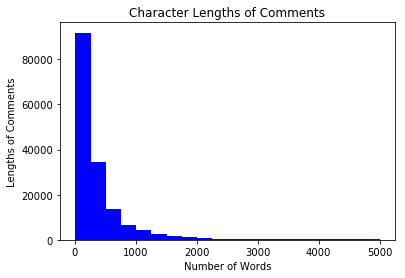

In [10]:
# Visualization of the Char lengths 
char_lengths = get_char_lengths(data)
import matplotlib.pyplot as plt
plt.hist(char_lengths, bins=20, color = "blue")
plt.title("Character Lengths of Comments")
plt.ylabel('Lengths of Comments')
plt.xlabel('Number of Words')
plt.savefig("char_lengths.png")
plt.show();

Let's also visualize the feature space using word clouds, to see frequently used ones. I used the python library available from https://github.com/amueller/word_cloud The initial clouds come from the first 1000 comments. 

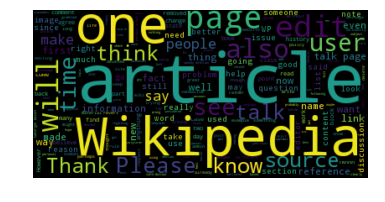

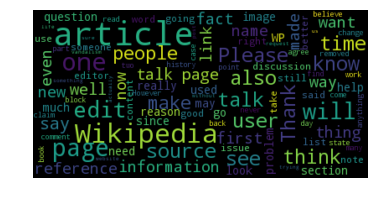

In [11]:
# concatenate the first 1000 
# comments into a string for 
# processing into the word cloud
text= "and"
for comment in data["comment_text"][:1000]:
    text += comment 
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
# feed the big string into the wordcloud
# and display it
wordcloud = WordCloud(max_font_size=40, max_words=100).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("all_w_cloud.png", bbox_inches='tight')
plt.show()

Now the first 1000 toxic comments: 

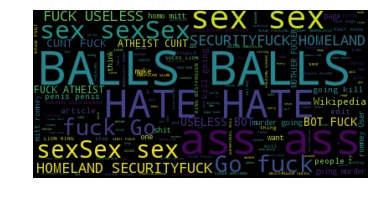

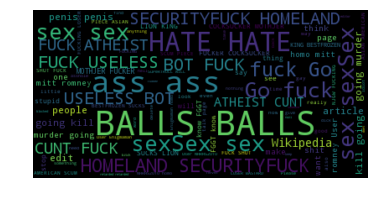

In [12]:
# concatenate the first 1000 
# toxic comments into a string for 
# processing into the word cloud
samples = first_n_toxic(data, 1000)
new_text = ""
for comment in samples: 
    new_text += comment; 
wordcloud = WordCloud().generate(new_text)    
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
# feed the big string into the wordcloud
# and display it
wordcloud = WordCloud(max_font_size=40, max_words=100).generate(new_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("toxic_w_cloud.png", bbox_inches='tight', pad_inches =0)
plt.show()

Quite the contrast. 

# Algorithms 

The baseline will be Naive Bayes, though for  binary classification tasks, support vector machines and logistic regression are also popular choices and will be tried as well.  

In [4]:
# separate the data into features (X)
# and labels (y), then
# split into test/train
X = data['comment_text']
y = data['toxic']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42)

These are convenience functions to output the class metrics and ROC curve: 

In [5]:
def class_metrics(y_test, y_preds):
    """
    Output the accuracy, precision, recall, and f-score
    
    Args: 
        y_test: the array of test labels (0/1)
        y_preds: the array of predicted labels 
    """
    print('Accuracy score: ', format(accuracy_score(y_test,y_preds)))
    print('Precision score: ', format(precision_score(y_test, y_preds)))
    print('Recall score: ', format(recall_score(y_test, y_preds)))
    print('F1 score: ', format(f1_score(y_test,y_preds)))

In [7]:
def draw_roc(y_test, y_preds):
    """
    Draw the ROC/AUC Curve
    
    Args: 
        y_test: the array of test labels (0/1)
        y_preds: the array of predicted labels 
    """
    fpr, tpr, threshold = roc_curve(y_test, y_preds)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.savefig("roc_auc.png")
    plt.show()

These functions will be used to examine false negatives and false positives yielded by the binary classifiers: 

In [8]:
def n_false_negatives(n, x, y, preds):
    """
    Return a set of comments falsely classified as negative
    
    Args: 
        n: number of false negatives to return 
        x: dictionary with comments 
        y: test set array 
        preds: predictions array 
    """
    count = 0
    samples = []
    for x_i, y_i, pred in zip(x, y, preds): 
        if y_i == 1 and pred == 0:
            samples.append(x_i)
            count += 1
        if count >= n: 
            break       
    return samples 

def n_false_positives(n, x, y, preds):
    """
    Return a set of comments falsely classified as positive
    
    Args: 
        n: number of false positives to return 
        x: dictionary with comments 
        y: test set array 
        preds: predictions array 
    """
    count = 0
    samples = []
    for x_i, y_i, pred in zip(x, y, preds): 
        if y_i == 0 and pred == 1:
            samples.append(x_i)
            count += 1
        if count >= n: 
            break       
    return samples     

# Baseline: Naive Bayes

## A first attempt 

Here, the model is fit after vectorizing the word inputs, and applying inverse document frequencies. 

In [17]:
# benchmark pipeline that vectorizes the words, 
# applys TFIDF, and Multinomial Naive Bayes
nb_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
                    ])

In [18]:
# Train the model 
nb_clf.fit(X_train, y_train)  

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [19]:
# Predict on test set, and run the metrics
nb_preds = nb_clf.predict(X_test)
class_metrics(y_test, nb_preds)

Accuracy score:  0.9217320466223837
Precision score:  0.9914893617021276
Recall score:  0.15743243243243243
F1 score:  0.2717201166180758


In [20]:
confusion_matrix(y_test, nb_preds)

array([[14476,     2],
       [ 1247,   233]], dtype=int64)

While the accuracy is ok at 92%, the precision and recall scores are starkly opposed. The precision is 99%, with only 5 false positives (non-toxic articles classified as toxic). However the recall is only 15%. And as can be seen from the confusion matrix, the classifier has only identified 559 of the 3815 toxic comments as such. In short, the NB is better at classifying non-toxic comments than toxic ones. In fact, having a default model that predicted 'non-toxic' everytime would perform close to this model's accuracy: 

In [21]:
# Give the accuracy of the naive model, 
# which guesses non-toxic (0) for every feature
print("Dumb model accuracy:", len(y_test[y_test == 0])/len(y_test))

Dumb model accuracy: 0.9072565484396541


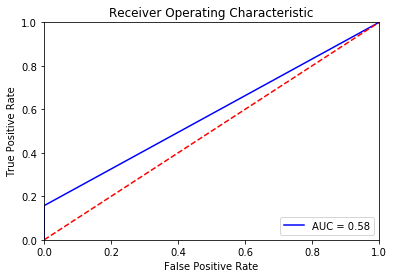

In [22]:
# Draw the ROC curve for the benchmark
draw_roc(y_test, nb_preds)

This clearly needs to be improved. 

## NB with Undersampling. 

This is an attempt to account for the highly imbalanced dataset, where 90% of the samples belong to the majority class, non-toxic comments. We make use of the imbalanced-learn package. 

http://contrib.scikit-learn.org/imbalanced-learn/stable/index.html

In [23]:
# form a pipeline with Vectorizer, TDIF, 
# Under Sampler objec, and MultinomialNB
# Train and predict
nb_clf_2 = make_pipeline_imb(TfidfVectorizer(),
                         RandomUnderSampler(),
                         MultinomialNB())

nb_clf_2.fit(X_train, y_train)
nb2_preds = nb_clf_2.predict(X_test)

In [24]:
# run metrics 
class_metrics(y_test, nb2_preds)

Accuracy score:  0.9209800726908134
Precision score:  0.5480895915678524
Recall score:  0.8432432432432433
F1 score:  0.6643598615916956


In [25]:
confusion_matrix(y_test, nb2_preds)

array([[13449,  1029],
       [  232,  1248]], dtype=int64)

As can be seen, the recall has increased greatly, due to the decreased amounts of False Negatives. Unfortunately, this has been counter-balanced by a greater number of false positives. But overall, the f-score has risen from 26% to 66%, a notable improvement. Taking a look at ROC/AUC:  

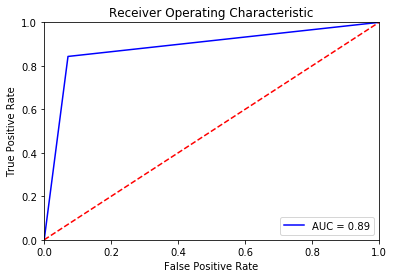

In [26]:
draw_roc(y_test, nb2_preds)

The curve has tacked to the upper left corner as would be expected. 

# SVM
Now, we'll train a support vector machine, the SGDclassifier which employs gradient descent. There was some experimentation with the penalty and other parameters. Adjusting the regularization parameter alpha in particular improved results. 

In [27]:
# Form a pipeline of Vectorizer, TFIDF, 
# SGDClassifier, train and predict
svm_clf = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('clf', SGDClassifier(loss='hinge', penalty='l1',
                                          alpha=1e-5, random_state=42,
                                          max_iter=10, tol=None)),
])
svm_clf.fit(X_train, y_train)
svm_preds = svm_clf.predict(X_test)  

Accuracy score:  0.9632159418473493
Precision score:  0.8906386701662292
Recall score:  0.6878378378378378
F1 score:  0.7762104460541365


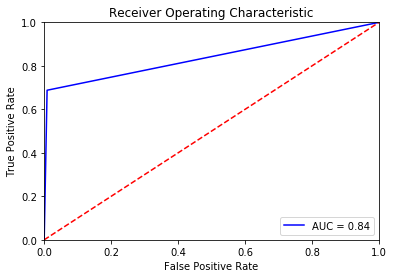

In [28]:
class_metrics(y_test, svm_preds)
draw_roc(y_test, svm_preds)

In [29]:
confusion_matrix(y_test, svm_preds)

array([[14353,   125],
       [  462,  1018]], dtype=int64)

The SGDClassifier is showing better results than Naive Bayes, the F-score is .77, compared to 27% for the baseline model, and 66% employing undersampling. 

## SVM With Undersampling

In [30]:
# Form a pipeline of Vectorizer, TFIDF, 
# SGDClassifier, UnderSampling, train and predict
svm_clf_2 = make_pipeline_imb(TfidfVectorizer(),
                         RandomUnderSampler(),
                         SGDClassifier(loss='hinge', penalty='l1',
                                           alpha=1e-5, random_state=42,
                                           max_iter=5, tol=None))

svm_clf_2.fit(X_train, y_train)
svm_preds_2 = svm_clf_2.predict(X_test)

In [31]:
class_metrics(y_test, svm_preds_2)

Accuracy score:  0.9093871412457701
Precision score:  0.5063527653213752
Recall score:  0.9155405405405406
F1 score:  0.6520692974013476


In [32]:
confusion_matrix(y_test, svm_preds_2)

array([[13157,  1321],
       [  125,  1355]], dtype=int64)

Performance has degraded, the F-Score dropping 14 points. Interestingly, the recall is higher than any other of the sklearn algorithms employed. The undersampling seems to have resulted in a model that's less conservative in classifying toxic comments. Unfortunately, it's also getting a disproportionate number of false positives. 

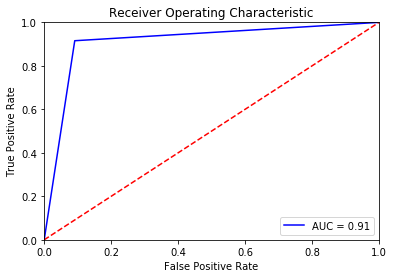

In [33]:
draw_roc(y_test, svm_preds_2)

# Logistic Regression

In [34]:
# Form a pipeline of Vectorizer, TFIDF, 
# Logistic Regression
lr_pipe =  Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', LogisticRegression())
                      ])

In [35]:
# train LR pipeline 
lr_pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [36]:
# predict with LR Pipeline 
lr_pred = lr_pipe.predict(X_test)

In [37]:
class_metrics(y_test, lr_pred)

Accuracy score:  0.9598320591552826
Precision score:  0.9133004926108375
Recall score:  0.6263513513513513
F1 score:  0.7430861723446894


In [40]:
confusion_matrix(y_test, lr_pred)

array([[14390,    88],
       [  553,   927]], dtype=int64)

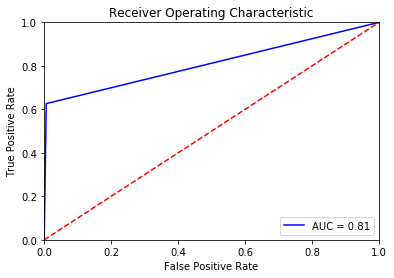

In [41]:
draw_roc(y_test, lr_pred)

The vanilla LR model has produced decent results, though still trailing SVM. There are a number of parameters which can be set with LR, however, so a gridsearch was performed. 

## Logistic Regression and GridSearch

In [9]:
# Note: the gridsearch was run from the command 
# line, the code is available as "logistic.py"

# use the parameters from the gridsearch in 
# the logistic regression link of the pipeline
# after vectorizing, TFIDF. Train model 
lr_pipe_2 =  Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
                       ('tfidf', TfidfTransformer()),
                       ('clf', LogisticRegression(C = 4, penalty="l1"))
                      ])
lr_pipe_2.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip...ty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [10]:
lr_pred_2 = lr_pipe_2.predict(X_test)

In [11]:
class_metrics(y_test, lr_pred_2)

Accuracy score:  0.9644065672390024
Precision score:  0.8413173652694611
Recall score:  0.7594594594594595
F1 score:  0.7982954545454546


Choosing the default penalty norm 'l1' (which tends to eliminate features), and a new regularization constant (C) has yielded the best f-score and accuracy thus far. Also, the ngram_range for the vectorizer was set to bigrams, and this bolstered performance. 

In [45]:
confusion_matrix(y_test, lr_pred_2)

array([[14266,   212],
       [  356,  1124]], dtype=int64)

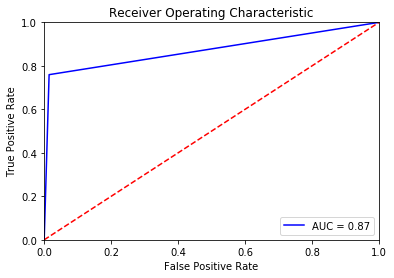

In [46]:
draw_roc(y_test, lr_pred_2)

## Testing Robustness 

The comments below were pulled from a thread of a political forum. Examples were picked that could clearly be seen as toxic or non-toxic. The LR model does classify them all correctly.

In [28]:
# These are comments pulled from 
# the same thread on a political forum
comments = ["It's unlike Trump to use an understatement in one of his branding attempts.", 
            """This from a Guy that never misses a day winning about how Trump is so dumb. 
            Get the fuck over you stupid ass self. The Russians have you talking jibberish.""",
            """I have never claimed to be brilliant. Trump is the one that is ranking on people's IQ, not me.
            Also I have "NEVER" tried to bring any Republican over to my side of thinking. By the way, 
            IMO Trump is a dumb idiot.""",
            """Bottom line is that Trump is smarter than you... which automatically makes you the dumber idiot.""",
            "Probably the only thing from turning his approval rating to 85%.",
            "Maxine Waters is our President?",
            """lol, true. But I don't think she's even very popular among her fellow Democrats. She may attack Trump 
            and some others in a way that Dems find amusing, but I don't think too many people on that side really take 
            her too seriously. Ever see her bumble her way through a tough interview? It's cringy and tough to watch. 
            You nearly feel embarrassed for her.""", 
            "My smugness has nothing to do with my superiority.",
            "I'm just glad that the country recovered those 170 million jobs that the sequestration cost us."
             ]
# predict toxicity for the chosen comments
lr_pipe_2.predict(comments)

array([0, 1, 1, 1, 0, 0, 0, 0, 0], dtype=int64)

In [48]:
# Run the previously defined functions to get examples 
# of comments the classifier has yielded a false negative. At least
# one of these  will be examined in the doc. 
fns = n_false_negatives(3, X_test, y_test, lr_pred_2)
for s in fns: 
    print("False Negative Comment: ", s, "\n" )

False Negative Comment:  please do not write me more!! Silly 

Perhaps no one has told you but you're obviously frustrated and I would like that please do not write me more. For my part I have decided that I will not bring anything more to wikipedia, because wikipedia is a monopoly of information manipulated by a lot of abnormals like you. 

False Negative Comment:  "

 Sockpuppet? 

Oh no Stifle. Just what do you think your doing? I've worked too hard for you to do this. And why? Dont assume, look at my contributions and what have I done? What ties me to ""Smugface"" (as you and every second person belives)? And what sets us apart? CONSTRUCTIVE EDITS! Thats bloody what! 

Remove or find an answer.

  

Not happy Jan!

 Could we not discuss this in the stead of dirtying up each others pages?   
Your contribution patterns are very similar - very little article contributions, causing general annoyance, and yelling at anyone who tries to call you on it.   " 

False Negative Comment:  Do n

In [51]:
# Run the previously defined functions to get examples 
# of comments the classifier has yielded a false positive. At least
# one of these  will be examined in the doc. 
fps = n_false_positives(3, X_test, y_test, lr_pred_2)
for p in fps: 
    print("False Positive Comment: ", p, "\n" )

False Positive Comment:  "

  is a scientifically proven epitome of an Arsehole (stretched and itching...) THAT's WHY he whines and bitches so pathetically on Wikipaedia 

Female masturbation techniques are quite numerous and perhaps more varied than those of males. They are influenced by a number of factors and personal preferences. Techniques include stroking or rubbing of the vulva, especially the clitoris, with the middle, index and/or second fingers. Sometimes one or more fingers may be inserted into the vagina to repeatedly stroke the frontal wall of the vagina where the g-spot is located. (Studies done by Masters & Johnson, however, have shown that only about 10% of women actually have orgasms through vaginal stimulation alone.) [citation needed] Masturbation aids such as a vibrator, dildo or Ben Wa balls can also be used to stimulate the vagina and clitoris. Many women will caress the breasts or stimulate a nipple with the free hand. Anal stimulation is also enjoyed by some bec

## Logistic Regression with Undersampling

In [54]:
# make a pipeline of Vectorizer, TFIDF, LR, 
# with under-sampling. Fit and predict. 
lr_pipe_3 = make_pipeline_imb(TfidfVectorizer(ngram_range=(1,2)),  
                                RandomUnderSampler(),
                                LogisticRegression(C=4, penalty='l1')
                                )

lr_pipe_3.fit(X_train, y_train)
lr_preds_3 = lr_pipe_3.predict(X_test)

In [55]:
class_metrics(y_test, lr_preds_3)

Accuracy score:  0.9241132974056899
Precision score:  0.5563468789275241
Recall score:  0.8972972972972973
F1 score:  0.686837341608482


In [56]:
confusion_matrix(y_test, lr_preds_3)

array([[13419,  1059],
       [  152,  1328]], dtype=int64)

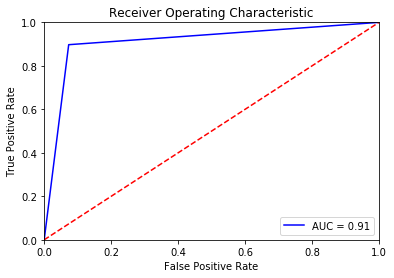

In [57]:
draw_roc(y_test, lr_preds_3)

# LSTM

The next option considered was a Neural Network. After some research on text classification, and the special challenges posed in Natural Language Processing, I decided to construct a form of Recurrent Neural Network known as an LSTM (Long Short Term Memory). 

In [66]:
# Note: Ran this once in Jupyter to get 
# the output below. However, when I was experimenting, 
# repeatedly trained from command line with the 
# project file "lstm_toxic.py" 

# Tokenize the text comments 
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
list_tokenized_train = tokenizer.texts_to_sequences(X_train)
list_tokenized_test = tokenizer.texts_to_sequences(X_test)

#Add padding
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

#Build model, 
embed_size = 128
inp = Input(shape=(maxlen, ))
# word embedding layer 
x = Embedding(max_features, embed_size)(inp)
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)
# add pooling layer and dropout 
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
# First Dense layer with relu
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
# Output layer, just 1 node for the 
# binary prediction 
x = Dense(1, activation="sigmoid")(x)

#Final Assembly, compile and summary
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           45360     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 60)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                3050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
__________

In [69]:
# file path for model weights, hdf5 format 
file_path="weights_base.best.hdf5"
#enable early stopping 
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_loss", mode="min", patience=4)
callbacks_list = [checkpoint, early]

In [70]:
# set the batch size, 
# of epochs, and train. 
batch_size = 64
epochs = 4
model.fit(X_t, y_train, 
          batch_size=batch_size, 
          epochs=epochs,
          callbacks = callbacks_list,           
          validation_split=0.1, 
          verbose = 2) 

Train on 129251 samples, validate on 14362 samples
Epoch 1/4
Epoch 00001: val_loss improved from inf to 0.10326, saving model to weights_base.best.hdf5
 - 597s - loss: 0.1382 - acc: 0.9522 - val_loss: 0.1033 - val_acc: 0.9616
Epoch 2/4
Epoch 00002: val_loss improved from 0.10326 to 0.09971, saving model to weights_base.best.hdf5
 - 594s - loss: 0.0869 - acc: 0.9677 - val_loss: 0.0997 - val_acc: 0.9634
Epoch 3/4
Epoch 00003: val_loss did not improve
 - 595s - loss: 0.0675 - acc: 0.9745 - val_loss: 0.1104 - val_acc: 0.9616
Epoch 4/4
Epoch 00004: val_loss did not improve
 - 596s - loss: 0.0498 - acc: 0.9814 - val_loss: 0.1278 - val_acc: 0.9596


In [71]:
#the outputs are probabilities, 
#map them to 0's and 1's to 
#calculate the metrics per usual 
preds = model.predict(X_te) 
preds[preds < 0.5] = 0
preds[preds >= 0.5] = 1
preds = preds.astype("int32")
# run the metrics
class_metrics(y_test, preds)

Accuracy score:  0.9598320591552826
Precision score:  0.7855684138869979
Recall score:  0.7797297297297298
F1 score:  0.7826381824347236


In [74]:
confusion_matrix(y_test, preds)

array([[14163,   315],
       [  326,  1154]], dtype=int64)

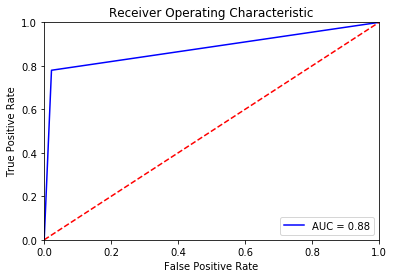

In [76]:
draw_roc(y_test, preds)

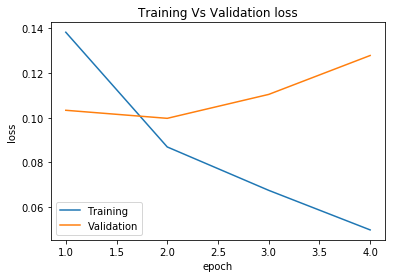

In [73]:
# training and validation losses 
# from the 4 epochs
train_loss = [0.1382, 0.0869, .0675, .0498]
val_loss = [0.1033, 0.0997, 0.1104, 0.1278]
epochs = np.arange(1,5,1)
# Graph of training vs validation loss 
plt.plot(epochs, train_loss)
plt.plot(epochs, val_loss)
plt.title('Training Vs Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='lower left')
plt.show()


We see evidence of overfitting quickly, during epoch 3. The training loss (using loss function "binary_crossentropy" from Keras) continues to decline, but the validation increases, meaning the extra weight calculations aren't useful. 